In [1]:
%load_ext autoreload
%autoreload 2  
%reload_ext autoreload

In [2]:
import numpy as np
import pickle
from tabulate import tabulate
from functools import partial
import ctypes
from scipy.optimize import minimize, LinearConstraint, dual_annealing, Bounds, NonlinearConstraint
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats.qmc import Sobol, Halton
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt 
import multiprocessing, tqdm
from bgspy.likelihood import FreeMutationModel
from bgspy.data import pi_from_pairwise_summaries
from bgspy.optim import optim_plot

In [3]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

# Fitting and Testing Optimization Procedures

Note that we often have to define specific fitting functions and run those — annoyingly when using Python's multiprocessing module, there's an issue where closures (functions that define functions around values) do not pickle and thus cannot be shipped off to other cores safely. So each test relies on a custom test function.

## Load data and define some functions

In [4]:
dat = pickle.load(open('../tests/likelihood_test_data.pkl', 'rb'))
B, Bp, Y, w, t = dat['B'], dat['Bp'], dat['Y'], dat['w'], dat['t']

bins = dat['bins']

nx, nw, nt, nf = B.shape
nparams = nt * nf + 2

assert nx == Y.shape[0]

In [5]:
B.shape

(2794, 6, 5, 2)

In [6]:
assert Bp.shape[0] == Y.shape[0]
assert B.shape[0] == Y.shape[0]

(array([ 44., 146., 344., 674., 740., 448., 241., 105.,  32.,  20.]),
 array([0.00045229, 0.00064934, 0.00084639, 0.00104344, 0.00124049,
        0.00143754, 0.00163459, 0.00183164, 0.00202869, 0.00222574,
        0.00242279]),
 <BarContainer object of 10 artists>)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


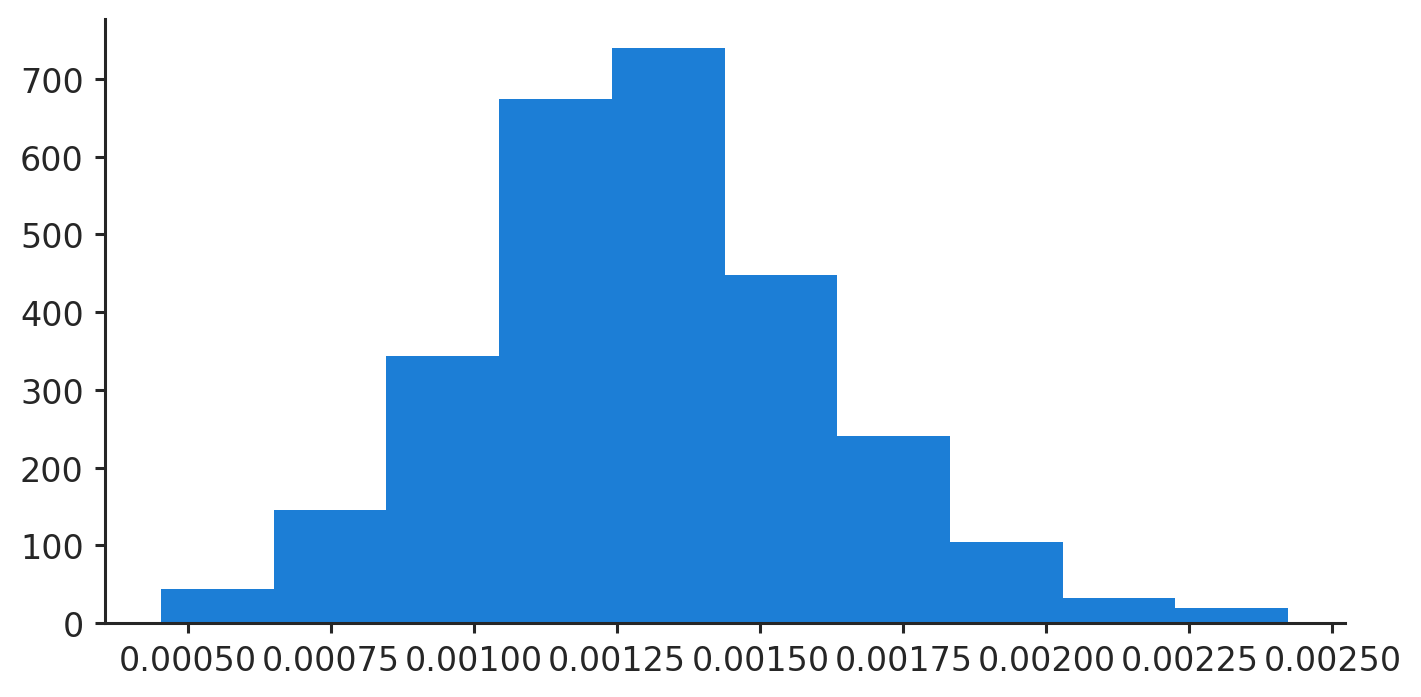

In [7]:
plt.hist(pi_from_pairwise_summaries(Y))

In [8]:
def negll_freemut(Y, B, w):
    def func(theta):
        new_theta = np.full(theta.size + 1, np.nan)
        theta = np.copy(theta)
        new_theta[0] = theta[0]
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = theta[1:] # times mutation rates
        #print("-->", theta, new_theta)
        return negll_c(new_theta, Y, B, w)
    return func

def run_optims(workerfunc, startfunc, nstarts, ncores = 50):
    starts = [startfunc() for _ in range(nstarts)]
    #import pdb; pdb.set_trace()
    with multiprocessing.Pool(ncores) as p:
        res = list(tqdm.tqdm(p.imap(workerfunc, starts), total=nstarts))
        #res = list(p.imap(workerfunc, starts))
    nlls = np.array([x.fun for x in res])
    thetas = np.array([x.x for x in res])
    success = np.array([x.success for x in res])
    return nlls, thetas, success, starts

def freemut_to_dfe(theta, nt, nf):
    assert nt*nf + 1 == theta.size
    M = theta[1:].reshape((nt, nf))
    muts = M.sum(axis=0)
    W = M / muts
    np.testing.assert_almost_equal(W.sum(axis=0), np.repeat(1., nf))
    return W, muts


In [25]:
from bgspy.likelihood import negll_freemut, random_start_mutation, bounds_mutation


nllB = negll_freemut(Y, B, w)
nllBp = negll_freemut(Y, Bp, w)

def worker_Bp_full(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, nf, paired=True), options={'eps':1e-9}, method='L-BFGS-B')

def worker_B_full(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, nf, paired=True), method='L-BFGS-B')

np.random.seed(1)
#resB = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 10_000)
resBp = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 10_000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:12<00:00, 32.05it/s]


In [9]:
Y.shape, Bp.shape

((2794, 2), (2794, 6, 5, 3))

In [26]:
freemut_to_dfe(resBp[1][np.argmin(resBp[0])], nt, nf), resBp[0][np.argmin(resBp[0])]

((array([[8.96452923e-01, 2.41719127e-02],
         [2.58867692e-02, 5.49272967e-02],
         [2.58867692e-02, 6.76921883e-02],
         [2.58867692e-02, 1.57953460e-04],
         [2.58867692e-02, 8.53050649e-01]]),
  array([3.86297723e-10, 6.33097875e-08])),
 1005698814485.9382)

In [11]:
freemut_to_dfe(resBp[1][np.argmin(resBp[0])], nt, nf), resBp[0][np.argmin(resBp[0])]

((array([[0.71393028, 0.59149479, 0.42074747],
         [0.10928823, 0.00137168, 0.15585612],
         [0.0680557 , 0.00137168, 0.162151  ],
         [0.05466435, 0.13541915, 0.05800806],
         [0.05406143, 0.2703427 , 0.20323735]]),
  array([1.84040881e-09, 7.29033369e-09, 9.37296936e-09])),
 1005142753574.1296)

In [12]:
theta = resBp[1][np.argmin(resBp[0])]

freemut_to_dfe(theta, nt, nf)

(array([[0.71393028, 0.59149479, 0.42074747],
        [0.10928823, 0.00137168, 0.15585612],
        [0.0680557 , 0.00137168, 0.162151  ],
        [0.05466435, 0.13541915, 0.05800806],
        [0.05406143, 0.2703427 , 0.20323735]]),
 array([1.84040881e-09, 7.29033369e-09, 9.37296936e-09]))

# Free-Mutation Model (SciPy)

Here we try a less-constrained form of optimization: a separate mutation rate per feature/selection class. This minimizes constraints — all we need are bounds. But, there are an extra two degrees of freedom. The simpler constraints mean we can try SciPy's optimiation function.

In [10]:
np.random.seed(1)
lik_bfgs = FreeMutationModel(w, t, logB=Bp, Y=Y)
lik_bfgs.fit(starts=50_000, ncores=70, algo='L-BFGS-B')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [22:42<00:00, 36.70it/s]


In [11]:
lik_bfgs

MLE (interpolated w): 6 x 5 x 2
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 1005698682297.7015
π0 = 0.0015860948765429315
W = 
-  ---------
1  0.0121874
1  0.326997
1  0.304389
1  0.0121874
1  4.34424
-  ---------
μ = 
-----  ----------
1e-11  1.2078e-08
-----  ----------

In [12]:
np.random.seed(1)
lik_nm = FreeMutationModel(w, t, Bp, Y=Y)
lik_nm.fit(starts=10_000, ncores=70, algo='NELDERMEAD')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [04:48<00:00, 34.62it/s]


In [13]:
lik_nm

MLE (interpolated w): 6 x 5 x 2
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 1005698461834.961
π0 = 0.0015873437854000139
W = 
--------  -----------
0.195103  0.000165012
0.195103  0.0581716
0.219587  0.0797315
0.195103  0.000165012
0.195103  0.861767
--------  -----------
μ = 
-----------  -----------
5.12549e-11  6.06017e-08
-----------  -----------

In [14]:
np.random.seed(1)
lik_isres = FreeMutationModel(w, t, Bp, Y=Y)
lik_isres.fit(starts=400, ncores=70, algo='ISRES')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [09:40<00:00,  1.45s/it]


In [15]:
lik_isres

MLE (interpolated w): 6 x 5 x 2
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 1005698824106.6721
π0 = 0.0015871143023984764
W = 
---------  ----------
0.3159     0.00369839
0.0987536  0.0554219
0.134296   0.0777181
0.207802   0.00771154
0.243248   0.85545
---------  ----------
μ = 
-----------  -----------
1.57758e-10  6.09653e-08
-----------  -----------

In [16]:
np.random.seed(1)
lik_nw = FreeMutationModel(w, t, Bp, Y=Y)
lik_nw.fit(starts=200, ncores=70, algo='NEWUOA')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [1:13:54<00:00, 22.17s/it]


In [17]:
lik_nw

MLE (interpolated w): 6 x 5 x 2
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 1005854011293.0314
π0 = 0.0015324533532815726
W = 
-----------  ----------
0.906067     0.00214529
0.0522002    0.0411335
0.000578908  0.0398173
0.0301765    0.286777
0.0109777    0.630127
-----------  ----------
μ = 
-----------  -----------
1.72739e-08  5.91541e-08
-----------  -----------

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


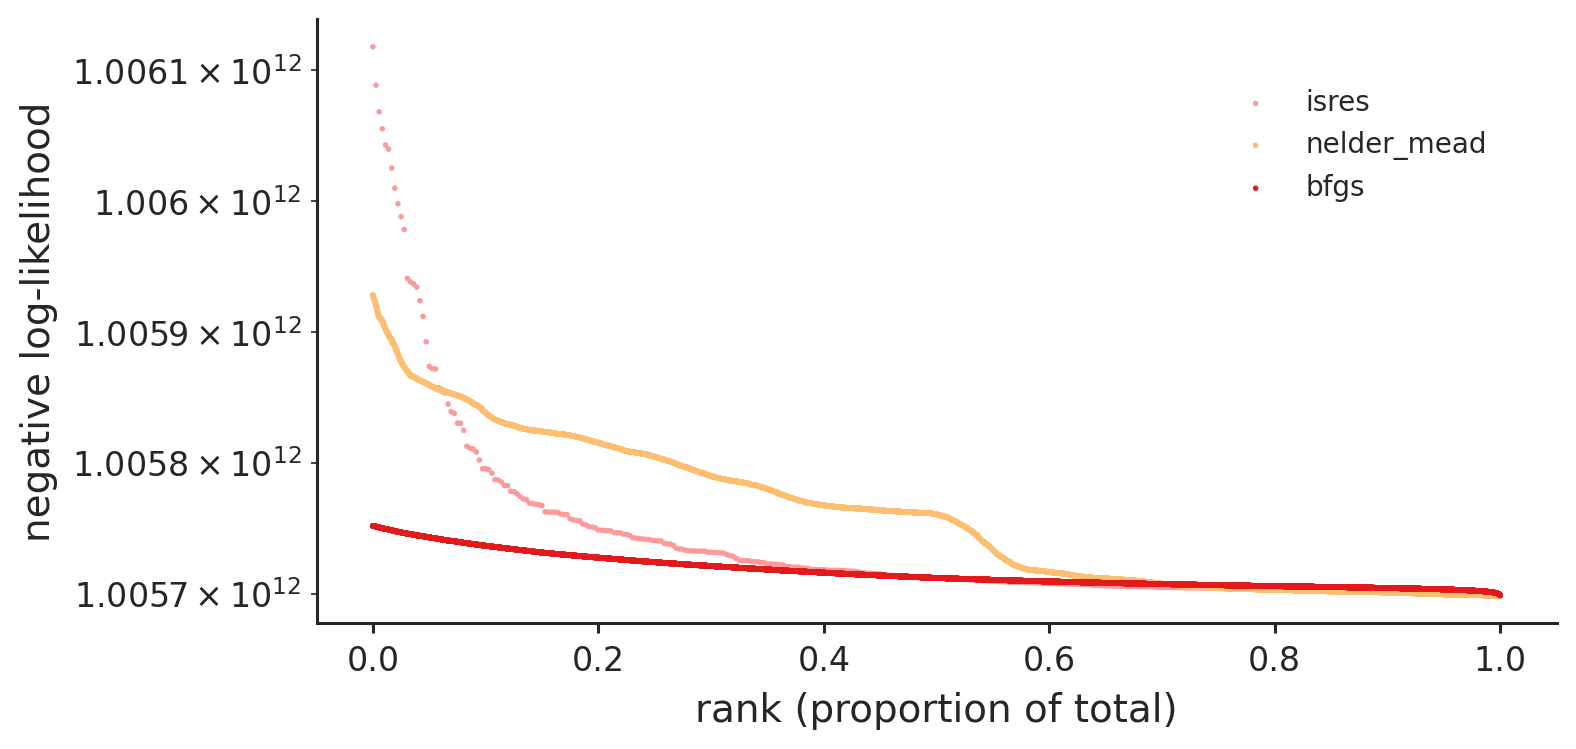

In [18]:
optim_plot(isres=lik_isres.optim, nelder_mead=lik_nm.optim, bfgs=lik_bfgs.optim, x_percent=True, tail=0.9)

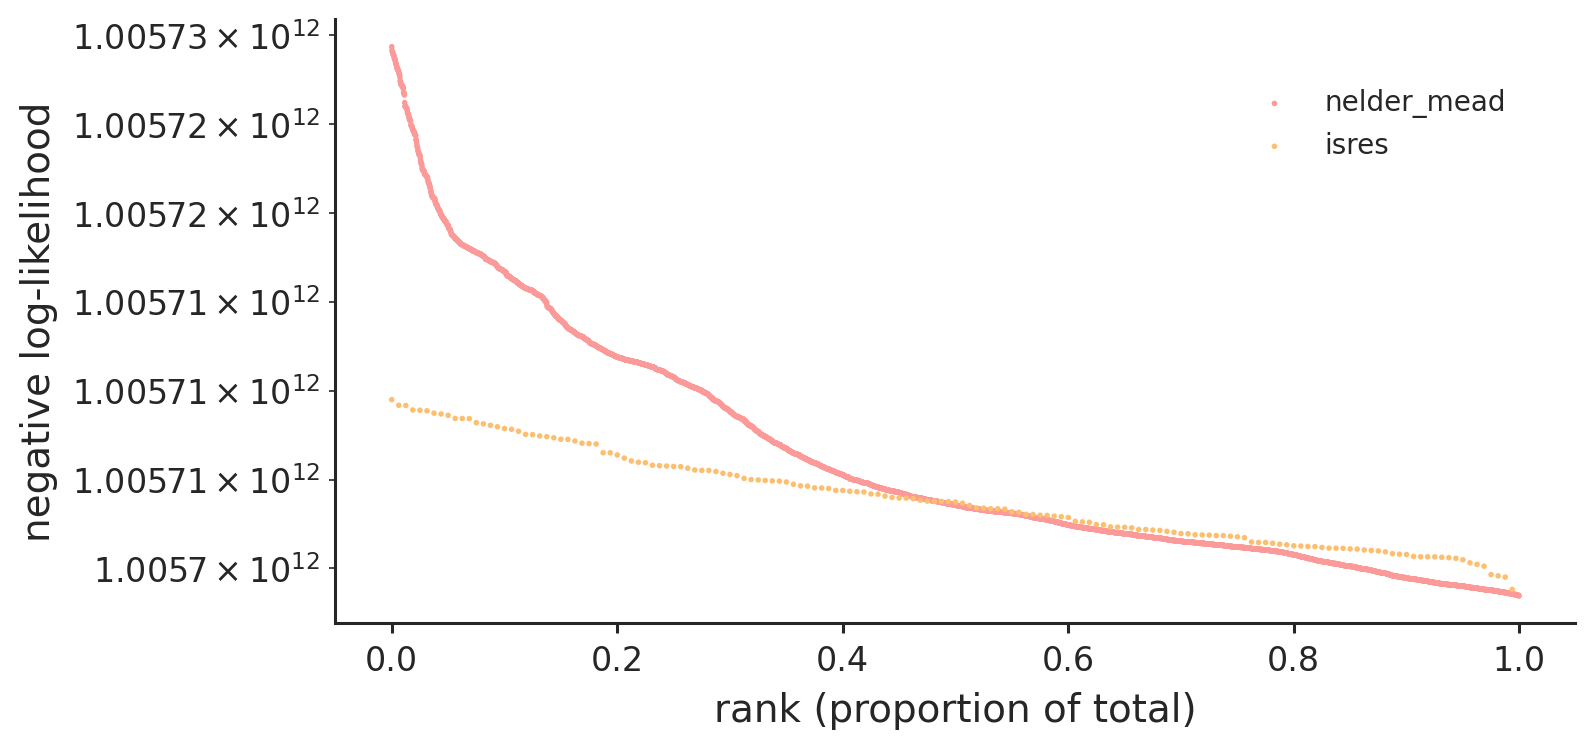

In [19]:
optim_plot(nelder_mead=lik_nm.optim, isres=lik_isres.optim, x_percent=True, tail=0.4)

Looks like Nelder-Mead and ISRES do well. Each ISRES optimization takes a tad longer, so we run fewer; for this reason the comparison is unfair. Let's downsample.

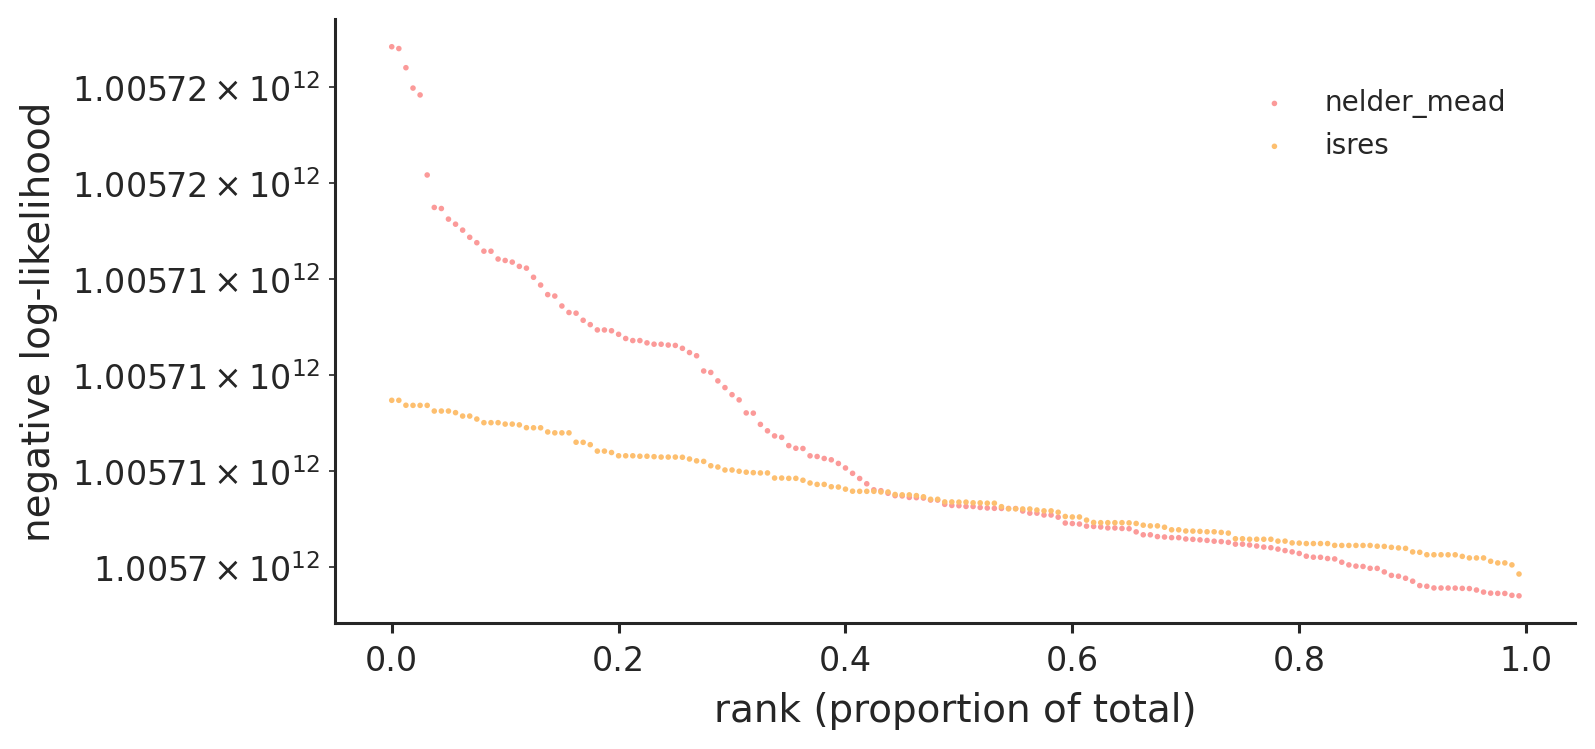

In [20]:
optim_plot(nelder_mead=lik_nm.optim, isres=lik_isres.optim, x_percent=True, 
           downsample=len(lik_isres.optim.nlls_), tail=0.4)

Nelder-Mead seems to do better. Let's run slightly larger runs. 

In [21]:
np.random.seed(0)
lik_nml = FreeMutationModel(w, t, Bp, Y=Y)
lik_nml.fit(starts=50_000, ncores=70, algo='NELDERMEAD')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [24:24<00:00, 34.14it/s]


In [22]:
lik_nml

MLE (interpolated w): 6 x 5 x 2
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]

Free-mutation model ML estimates:
negative log-likelihood: 1005698457994.7966
π0 = 0.001585614196534346
W = 
--------  -----------
0.198426  0.000165648
0.198426  0.0584447
0.206297  0.0787337
0.198426  0.000165648
0.198426  0.86249
--------  -----------
μ = 
-----------  -----------
5.03967e-11  6.03688e-08
-----------  -----------

NameError: name 'theta_i' is not defined

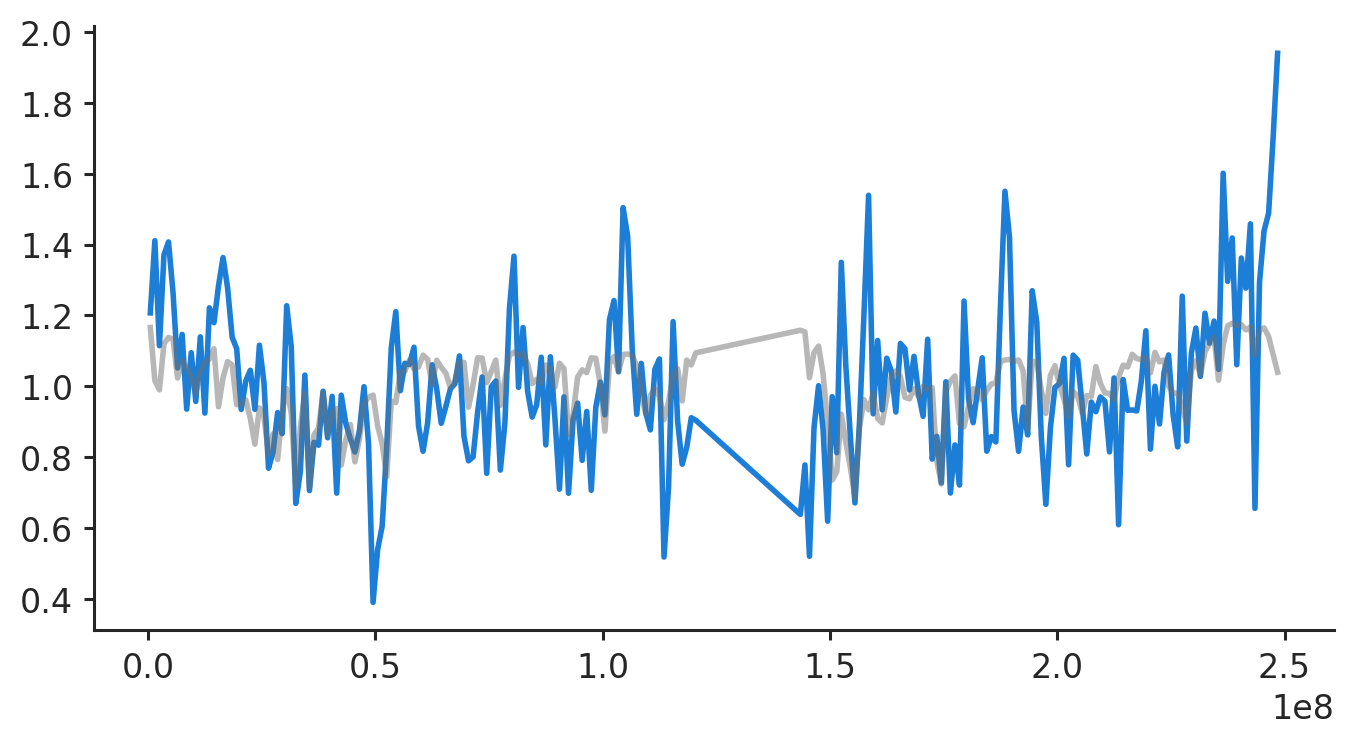

In [23]:
chrom = 'chr1'
i = np.array([i for i, (c, s, e) in enumerate(bins) if c == chrom])
x = np.array([(s+e)/2 for i, (c, s, e) in enumerate(bins) if c == chrom])

def ratio(x):
    return x/np.nanmean(x)

plt.plot(x, ratio(pi_from_pairwise_summaries(lik_nml.Y)[i]), linewidth=2)
ths = []
for ii in range(10):
    #theta_i = np.random.randint(0, lik_nml.optim.thetas_.shape[0])
    plt.plot(x, ratio(lik_nml.predict(optim=ii)[i]), c='0.44', alpha=0.5, linewidth=2)
    ths.append(theta_i)

    
plt.plot(x, ratio(lik_nml.predict()[i]), c='r', linewidth=2)
plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {lik_nml.R2():.2}$")

In [ ]:
chrom = 'chr10'
i = np.array([i for i, (c, s, e) in enumerate(bins) if c == chrom])
x = np.array([(s+e)/2 for i, (c, s, e) in enumerate(bins) if c == chrom])

def ratio(x):
    return x/np.nanmean(x)

plt.plot(x, ratio(pi_from_pairwise_summaries(lik_nml.Y)[i]), linewidth=2)
ths = []
for ii in range(10):
    #theta_i = np.random.randint(0, lik_nml.optim.thetas_.shape[0])
    plt.plot(x, ratio(lik_nml.predict(optim=ii)[i]), c='0.44', alpha=0.5, linewidth=2)
    ths.append(theta_i)

    
plt.plot(x, ratio(lik_nml.predict()[i]), c='r', linewidth=2)
plt.ylabel("$\pi/\\bar{\pi}$")
plt.xlabel("position")
plt.title(f"$R^2 = {lik_nml.R2():.2}$")

In [ ]:
plt.scatter(lik_nml.predict(), lik_nml.resid(), c='k', alpha=0.2)
theta = np.sort(lik_nml.predict())
#theta = np.sort(pi_from_pairwise_summaries(lik_nml.Y))

plt.plot(theta, 2*theta**2 / 9, c='r', linewidth=2, linestyle='dashed')
plt.semilogy()

In [ ]:
2*theta**2 / 9


In [ ]:
lik_nml

In [ ]:
fig, ax = plt.subplots()
ax.scatter(pi_from_pairwise_summaries(lik_nml.Y), lik_nml.predict(), c='k', alpha=0.1)
ax.axline((1e-3, 1e-3), slope=1, c='r')

In [ ]:
np.random.seed(0)
lik_isresl = FreeMutationModel(w, t, Bp, Y=Y)
lik_isresl.fit(starts=5_000, ncores=70, algo='ISRES')

In [ ]:
lik_isresl

In [ ]:
optim_plot(isresl=lik_isresl.optim, nelder_mead=lik_nml.optim, 
           x_percent=True, downsample=len(lik_isresl.optim.nlls_), tail=0.1)

# SCRATCH

In [ ]:
np.random.seed(0)
lik_nml2 = FreeMutationModel(w, t, Bp, Y=Y)
lik_nml2.fit(starts=50_000, ncores=70, algo='NELDERMEAD')

In [ ]:
optim_plot(Bp=lik_scipy.optim, tail=0.1)

In [ ]:
lik_nlopt = FreeMutationModel(w, t, Bp, Y=Y)
lik_nlopt.fit(starts=100, ncores=70, algo='isres')

In [ ]:
lik_nlopt

In [ ]:
lik_scipy.mle_W / lik_scipy.mle_W.sum(axis=0)

In [ ]:
lik_nlopt = FreeMutationModel(w, t, B, Y=Y)
lik_nlopt.fit(starts=10, ncores=70, engine='nlopt')

In [ ]:
lik_nlopt, lik_scipy

In [ ]:
lik_nlopt.optim.theta[1:].reshape((nt, nf)) / lik_nlopt.optim.theta[1:].reshape((nt, nf)).sum(axis=0)

## Free-Mutation Model with Reduced Features Model

Here we try the simplest test case: only one column of features (CDS) of the test human data.
 

In [ ]:
def negll_freemut(Y, B, w):
    def func(theta):
        new_theta = np.full(theta.size + 1, np.nan)
        theta = np.copy(theta)
        new_theta[0] = theta[0]
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = theta[1:] # times mutation rates
        #print("-->", theta, new_theta)
        return negll_c(new_theta, Y, B, w)
    return func

In [ ]:
w

In [ ]:
Y.shape, B.shape

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA(n_components=2)

thetas = lik.optim.thetas
nlls = lik.optim.nlls#[lik.optim.rank[:50]]
thetas = thetas#[lik.optim.rank[:50]]
scaler = StandardScaler()
thetaz = scaler.fit(thetas).transform(thetas)
thetaz = thetas

plt.scatter(*pca.fit(thetaz).transform(thetaz).T, c=np.log10(nlls))

In [ ]:
pca.explained_variance_ratio_

In [ ]:
nllBp = negll_freemut(Y, Bp[..., 0][..., None], w)
nllB = negll_freemut(Y, B[..., 0][..., None], w)

In [ ]:
optim_plot(B=resB_reduced, Bp=resBp_reduced, tail=0.7)
plt.semilogy()

## Free-Mutation Model (All Features)

First we try with SciPy's `minimize()` function:

In [ ]:
from bgspy.likelihood import negll_freemut, random_start_mutation
from bgspy.optim import run_optims

nllBp = negll_freemut(Y, Bp, w)
nllB = negll_freemut(Y, B, w)

def worker_Bp_full(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, nf, paired=True), options={'eps':1e-9}, method='L-BFGS-B')

def worker_B_full(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, nf, paired=True), method='L-BFGS-B')

starts = [random_start_mutation(nt, nf) for _ in range(100)]
#resB = run_optims(worker_Bp_full, starts, 10_000)
resBp = run_optims(worker_Bp_full, starts, 10_000)

In [ ]:
starts

In [ ]:
summarize_optims(resB, nt, nf)
summarize_optims(resBp, nt, nf)

Now let's try with NLOpt's optimization approaches.

In [ ]:
def negll_freemut_nlopt(Y, B, w):
    def func(x, grad):
        new_theta = np.zeros(x.size + 1)
        new_theta[0] = x[0]
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = x[1:] # times mutation rates        
        return negll_c(new_theta, Y, B, w)
    return func

In [ ]:
nparams = nt*nf+1
opt = nlopt.opt(nlopt.GN_ISRES, nparams)
nllBp = negll_freemut_nlopt(Y, Bp, w)

# set the objective
opt.set_min_objective(nllBp) 

# set bounds
lb, ub = bounds_mutation(nt, nf)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

In [ ]:
%%time
#np.random.seed(0)
# stopping criteria:
opt.set_xtol_rel(1e-5)
opt.set_maxeval(10000000)

# random start
x = random_start_mutation(nt, nf)
assert x.size == nparams

# run
res = opt.optimize(x)

In [ ]:
opt

In [ ]:
e = res[1:].reshape((nt, nf))
res[0], e.sum(axis=0), e/e.sum(axis=1)[:, None], opt.last_optimum_value()

# Simplex Model (NLOpt)

The simplex model is an $n_t \times n_f$ matrix $\mathbf{W}$ which are DFE weights (columns sum to 1). The mutation rate per selection class, per feature class is then $\mu \mathbf{W}$.

The bounds of $\mathbf{W}$ are $[0, 1]$, and the constraint is $\sum_j w_{i,j} = 1$ However, there is also a total mutation bound, $\mu_l \le \mu \le \mu_u$. So, 

$$ \mu_l \le \mu \mathbf{W} \le \mu_u$$

In [ ]:
def negll_nlopt(Y, B, w):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        return negll_c(x, Y, B, w)
    return func

In [24]:
def constraint_matrix(nt, nf):
    nparams = nt*nf + 2
    A = np.zeros((nf, nparams))
    for i in range(nf):
        W = A[i, 2:].reshape((nt, nf))
        W[:, i] = 1.
    return A

def inequality_constraint_functions(nt, nf, log10_mu_bounds=(-11, -7)):
    """
     l < μW < u
     l - μW < 0
     μW - u < 0
    """
    A = constraint_matrix(nt, nf)
    lower, upper = 10**log10_mu_bounds[0], 10**log10_mu_bounds[1]
    def func_l(result, x, grad):
        mu = x[1]
        M = lower - (mu *  A.dot(x))
        for i in range(nf):
            result[i] = M[i]
    def func_u(result, x, grad):
        mu = x[1]
        M = (mu *  A.dot(x)) - upper
        for i in range(nf):
            result[i] = M[i]
    return func_l, func_u

def equality_constraint_function(nt, nf):
    A = constraint_matrix(nt, nf)
    def func(result, x, grad):
        M = A.dot(x)
        for i in range(nf):
            result[i] = M[i] - 1.
    return func

## A simple NLOpt single run test

In [38]:
constraint_matrix(nt, nf)[1, :][2:].reshape((nt, nf))

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [42]:
np.arange(nt*nf + 2)[2:].reshape((nt, nf))

array([[ 2,  3],
       [ 4,  5],
       [ 6,  7],
       [ 8,  9],
       [10, 11]])

In [39]:
constraint_matrix(nt, nf).dot(np.arange(nt*nf + 2))

array([30., 35.])

In [ ]:
Y.shape, Bp.shape

In [ ]:
hl, hu = inequality_constraint_functions(nt, nf)
ce = equality_constraint_function(nt, nf)

# NOTE: we do not have a start-based test of these bounds
# because it looks like SWIG's interface to NLOPT wraps this in a 
# weird way

In [ ]:
nparams = nt * nf + 2 # 1 for mutation rate, one for π0
# specify the algorithm
#opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
opt = nlopt.opt(nlopt.GN_ISRES, nparams)

# create a closure around the data
nll = negll_nlopt(Y, Bp, w)

# set the objective
opt.set_min_objective(nll) 

# specify tolerances and constraints
tols = np.repeat(1e-11, nf)
opt.add_inequality_mconstraint(hl, tols)
opt.add_inequality_mconstraint(hu, tols)
opt.add_equality_mconstraint(ce, tols)

# set bounds
lb, ub = bounds_simplex(nt, nf)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

In [ ]:
%%time
np.random.seed(1231)
# stopping criteria:
#opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-04] * nt*nf))
opt.set_xtol_rel(1e-3)
#opt.set_ftol_abs(1e8)
#opt.set_stopval(923543002497)
opt.set_maxeval(10000000)

# random start
x = random_start_simplex(nt, nf)
assert x.size == nparams

# run
res = opt.optimize(x)

In [ ]:
# mle theta, nll:
res, opt.last_optimum_value(), opt.last_optimize_result()

In [ ]:
res[0], res[1], np.round(res[2:].reshape((nt, nf)), 2), opt.last_optimum_value()

In [ ]:
res[2:].reshape((nt, nf)).sum(axis=0)

In [ ]:
opt.get_initial_step(x)

## Exploratory ISRES Global Runs

In [ ]:
# this wraps the nloptimization call
def nlopt_isres_worker(x, nt, nf):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.GN_ISRES, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_nlopt(Y, Bp, w)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_rel(1e-3)
    #opt.set_xtol_abs(1e-6)
    #opt.set_stopval(923543002497)
    opt.set_maxeval(1000000)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

In [ ]:
%%time
N = 200

np.random.seed(0)
worker = partial(nlopt_isres_worker, nt=nt, nf=nf)
isres_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

In [ ]:
best_theta = nloptim_summary(isres_run_res, nt, nf) # isres run

Now, let's compare the performance of the free mutation model with random starts and local optimization to the ISRES simplex model:

In [ ]:
optim_plot(isres=isres_run_res, B=resB_reduced, Bp=resBp_reduced, tail=0.4)
plt.semilogy()

In [ ]:
isres_run_res[0].max()

## Free-Mutation Model (All Features, Gaussian LL)

In [ ]:
def normal_negll_freemut(Y, B, w):
    def func(theta):
        new_theta = np.zeros(theta.size + 1)
        new_theta[0] = theta[0]
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = theta[1:] # times mutation rates        
        return -normal_ll_c(new_theta, Y, B, w)
    return func

In [ ]:
nllBp = normal_negll_freemut(Y, Bp, w)
nllB = normal_negll_freemut(Y, B, w)

def worker_Bp_full(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, nf, paired=True), options={'eps':1e-9}, method='L-BFGS-B')

def worker_B_full(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, nf, paired=True), method='L-BFGS-B')

resB = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 100_000)
resBp = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 100_000)

In [ ]:
plt.scatter(np.sum((resBp[1][np.argmin(resBp[0])][None, :] - resBp[1])**2, axis=1), resBp[0])

In [ ]:
cutoff = resBp[0] < np.quantile(resBp[0], 0.01)
_ = plt.hist(resBp[1][cutoff, 2], 10)

In [ ]:
optim_plot(Bp=resBp, tail=0.01)

In [ ]:
optim_plot(B=resB, Bp=resBp, tail=0.1)
plt.semilogy()

## Free Mutation Model with MVN

In [ ]:
from scipy.sparse import lil_matrix

def random_start_mvn(nt, nf):
    theta = random_start_mutation(nt, nf)
    new_theta = np.empty(nt*nf + 3)
    new_theta[0] = theta[0]
    new_theta[1] = np.abs(np.random.normal(0, 1, 1))
    new_theta[2] = stats.invgamma(5).rvs(1)
    new_theta[3:] = theta[1:]
    return new_theta
    

def mvn_nll(Y, B, w, bins):
    TINY = 1e-8
    nx, nw, nt, nf = B.shape
    n = Y.shape[0]
    nS = Y[:, 0]
    nD = Y[:, 1]
    # reparameterized data under MVN approximation
    N = nS + nD

    def func(theta): 
        Sigma = np.zeros((n, n), dtype=float)
        pi0 = theta[0]
        alpha = theta[1]
        rho = theta[2]
        W = theta[3:].reshape((nt, nf))
        
        logBw = np.zeros(nx, dtype=float)
        for i in range(nx):
            for j in range(nt):
                for k in range(nf):
                    logBw[i] += np.interp(W[j, k], w, B[i, :, j, k])

        log_pibar = np.log(pi0) + logBw
        pi = np.exp(log_pibar)
        mean = N * pi
        var = N * (1-pi) * pi
    
        for i in range(n):
            for j in range(i, n):
                if bins[i][0] == bins[j][0]:
                    # same chromosome
                    Sigma[i, j] = np.sqrt(N[i] * N[j])*alpha**2  * np.exp(-0.5 / rho**2 * (i - j)**2) + var[i]*(i==j) + TINY
                    Sigma[j, i] = Sigma[i, j]
        return -stats.multivariate_normal.logpdf(x=nD, mean=mean, cov=Sigma)
    return func

def mvn_bounds(nt, nf):
    lb, ub = bounds_mutation(nt, nf)
    lb = lb.tolist()
    ub = ub.tolist()
    lb.insert(1, 0) # alpha
    ub.insert(1, np.Inf) # alpha
    lb.insert(2, 0) # rho
    ub.insert(2, np.Inf) # rho
    return list(zip(lb, ub))

In [ ]:
mvnnll = mvn_nll(Y, Bp, w, bins)

In [ ]:
mvnnll(random_start_mvn(nt, nf))

In [ ]:
len(mvn_bounds(nt, nf)), len(random_start_mvn(nt, nf))

In [ ]:
minimize(mvnnll, x0=random_start_mvn(nt, nf), bounds=mvn_bounds(nt, nf))

In [ ]:
a = _

## Large Exploratory Multistart Local Runs

In [ ]:

# this wraps the nloptimization call
def nlopt_worker(x, nt, nf):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_nlopt(Y, Bp, w)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    #opt.set_xtol_abs(np.array([1e-4, 1e-17] + [1e-6] * nt*nf))
    opt.set_xtol_rel(1e-1)
    #opt.set_ftol_abs(1e-8)
    opt.set_maxeval(100000)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

In [ ]:
%%time
N = 1_000_000

#def best(theta):
#    return theta

np.random.seed(1)
worker = partial(nlopt_worker, nt=nt, nf=nf) 
#global_run_res = run_nloptims(worker, partial(best, theta=best_theta), N)
global_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

In [ ]:
optim_plot(global_run=global_run_res, tail=0.01)

In [ ]:
best_theta = nloptim_summary(global_run_res, nt, nf, 0)

## Fixing Mutation Rate

In [ ]:
constraint_matrix_fixedmu(nt, nf)[1, 1:].reshape((nt, nf))

In [ ]:
def constraint_matrix_fixedmu(nt, nf):
    nparams = nt*nf + 1
    A = np.zeros((nf, nparams))
    for i in range(nf):
        W = A[i, 1:].reshape((nt, nf))
        W[:, i] = 1.
    return A

def inequality_constraint_functions_fixedmu(nt, nf, mu):
    """
     l < μ W < u
     l - μ W < 0
     μ W - u < 0
    """
    A = constraint_matrix_fixedmu(nt, nf)
    lower = 0
    upper = 1
    def func_l(result, x, grad):
        M = lower - (mu *  A.dot(x))
        for i in range(nf):
            result[i] = M[i]
    def func_u(result, x, grad):
        M = (mu *  A.dot(x)) - upper
        for i in range(nf):
            result[i] = M[i]
    return func_l, func_u

def equality_constraint_function_fixedmu(nt, nf):
    A = constraint_matrix_fixedmu(nt, nf)
    def func(result, x, grad):
        M = A.dot(x)
        for i in range(nf):
            result[i] = M[i] - 1.
    return func


def negll_fixedmu_nlopt(Y, B, w, mu):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        theta = np.empty(x.size + 1)
        theta[0] = x[0]
        theta[1] = mu
        theta[2:] = x[1:].flat
        return negll_c(theta, Y, B, w)
    return func

def bounds_simplex_fixedmu(nt, nf, log10_pi0_bounds=(-4, -2),
           paired=False):
    l = [10**log10_pi0_bounds[0]]
    u = [10**log10_pi0_bounds[1]]
    l += [0.]*nf*nt
    u += [1.]*nf*nt
    lb = np.array(l)
    ub = np.array(u)
    assert np.all(lb < ub)
    if paired:
        return list(zip(lb, ub))
    return lb, ub


def nlopt_fixedmu_worker(x, nt, nf, mu):
    nparams = nt*nf + 1
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_fixedmu_nlopt(Y, Bp, w, mu)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions_fixedmu(nt, nf, mu)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function_fixedmu(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex_fixedmu(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    #opt.set_xtol_abs(np.array([1e-4, 1e-17] + [1e-6] * nt*nf))
    opt.set_xtol_rel(1e-1)
    #opt.set_ftol_abs(1e-8)
    opt.set_maxeval(100000)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

def random_start_simplex_fixedmu(nt, nf, log10_pi0_bounds=(-4, -3)):
    pi0 = 10**np.random.uniform(log10_pi0_bounds[0], log10_pi0_bounds[1], 1)
    W = np.empty((nt, nf))
    for i in range(nf):
        W[:, i] = np.random.dirichlet([1.] * nt)
        assert np.abs(W[:, i].sum() - 1.) < 1e-5
    theta = np.empty(nt*nf + 1)
    theta[0] = pi0
    theta[1:] = W.flat
    return theta

In [ ]:
%%time
N = 10_000

np.random.seed(1)
worker = partial(nlopt_fixedmu_worker, nt=nt, nf=nf, mu=1e-8) 
fixedmu_run_res = run_nloptims(worker, partial(random_start_simplex_fixedmu, nt=nt, nf=nf), N)

In [ ]:
nloptim_summary(fixedmu_run_res, nt, nf, 0)

In [ ]:
optim_plot(fixedmu=fixedmu_run_res, tail=0.01)

In [ ]:
plt.hist(global_run_res[1][np.argsort(global_run_res[0])[:10000]][:, 1])

In [ ]:
best = thetas[np.aargsort(nlls)[200]]

N = 5_000_000

#np.random.seed(1)
worker = partial(nlopt_worker, nt=nt, nf=nf) 
global_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

In [ ]:
optim_plot(global_run=global_run_res, tail=0.001)

In [ ]:
best_theta = nloptim_summary(global_run_res, nt, nf) # 3rd run

In [ ]:
best_theta = nloptim_summary(global_run_res, nt, nf) # 2nd run

In [ ]:
best_theta = nloptim_summary(global_run_res, nt, nf) # first run

In [ ]:
bt = np.array([0.00195829561471389, 1.232386727173979e-08, 0.574 , 0.751,  0.906,
          0.002 , 0.098,  0.074, 0.044,  0.029,  0.001, 0   ,   0.011 , 0.012,
          0.381,  0.11,   0.008])
          

### Experimental Perturbation Starts

It could be an issue of choosing the right perturbation scale, but this looked like it didn't work. I think that this is more becausing finding the true MLE in this space is hard — there are lots of local optima that need to be explored.

In [ ]:
def trunc_normal(loc, scale, lower, upper):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return np.random.normal(loc, scale)
    return truncnorm.rvs(a, b)

def perturber(theta, log10_pi0_bounds=(-4, -3),
            log10_mu_bounds=(-11, -7), pi0_scale=1e-6, 
            mu_scale=1e-12, dfe_scale=1e-04):
    def func():
        new_theta = np.copy(theta)
        normal = truncnorm.rvs

        new_theta[0] = trunc_normal(theta[0], pi0_scale, 10**log10_pi0_bounds[0], 10**log10_pi0_bounds[1])
        new_theta[1] = trunc_normal(theta[1], mu_scale, 10**log10_mu_bounds[0], 10**log10_mu_bounds[1])
        for i in range(2, theta.size):
            w = theta[i]
            new_theta[i] = trunc_normal(w, dfe_scale, 10**log10_mu_bounds[0]/w, 10**log10_mu_bounds[1]/w)
        return new_theta
    return func

In [ ]:
perturb_starts = perturber(best_theta)
run_res = run_nloptims(worker, perturb_starts, 4000)

In [ ]:
optim_plot(test=run_res, tail=0.6)

## Penalized Methods

Some of the instability of convergence to the optimum is that the model cannot choose between weak or strong mutation (and visa versa for selection). 

We could put a prior on this mutation rate, since we have many other estimates. A recent paper (Tian, Browning, and Browning, 2019) estimated the mutation rate as $\mu = 1.28 \times 10^{-8}$ ($95\%$ CI, $1.02 \times 10^{-8}, 1.56 \times 10^{-8}$).

In [ ]:
sigma

In [ ]:
mean = 1.28e-8
ci = [1.02e-8, 1.56e-8]

def ci2params(mean, ci, alpha=0.05):
    crit = stats.norm.ppf(1 - alpha/2)
    sigma1 = (mean-ci[0])/crit
    sigma2 = (ci[1]-mean)/crit
    return mean, np.mean((sigma1, sigma2))

mean, sigma = ci2params(mean, ci)

z = np.linspace(mean - 2.5*sigma, mean + 2.5*sigma, 1000)
y = stats.norm(mean, sigma).pdf(z)
plt.plot(z, y)
#plt.hist(stats.norm(mean, sigma).rvs(10000), 100, density=True)
#plt.axvline(mean -sigma)
plt.axvline(ci[0])
plt.axvline(ci[1])

In [ ]:
r = 1/(sigma / 1e3)**2

r, -r * (mean - 4.6e-9)**2 / 2 / 1e11

In [ ]:
(mean - 4.6e-9)**2

In [ ]:
negll_c(best_theta, Y, B, w), penalized_negll_c(best_theta, Y, B, w, 1.23e-8, r = r)

In [ ]:
def penalized_negll_nlopt(Y, B, w, mu0, r):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        return penalized_negll_c(x, Y, B, w, mu0, r)
    return func


def penalized_nlopt_worker(start, nt, nf, mu0, r):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.LN_BOBYQA, nparams)    
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = penalized_negll_nlopt(Y, Bp, w, mu0=mu0, r=r)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-4] * nt*nf))
    #opt.set_ftol_abs(1e8)
    #opt.set_stopval(923543002497)
    opt.set_maxeval(100000)
    x = random_start_simplex(nt, nf)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

N = 10_000

np.random.seed(1)
worker = partial(penalized_nlopt_worker, nt=nt, nf=nf, mu0=1.23e-8, r=0) 
#penalized_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

## Scratch

In [ ]:

def normal_negll_freemut_nlopt(Y, B, w):
    def func(x, grad):
        new_theta = np.zeros(x.size + 1)
        new_theta[0] = x[0]
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = x[1:] # times mutation rates        
        return -normal_ll_c(new_theta, Y, B, w)
    return func

In [ ]:
worker(random_start_simplex(nt, nf))

In [ ]:
nloptim_summary(penalized_run_res, nt, nf)

In [ ]:
optim_plot(penalized_run=penalized_run_res)

In [ ]:
optim_plot(penalized_run=penalized_run_res, tail=0.01)

In [ ]:
pbr = nloptim_summary(penalized_run_res, nt, nf)

In [ ]:
pbr = nloptim_summary(penalized_run_res, nt, nf)

In [ ]:
nloptim_summary(penalized_run_res, nt, nf)

## LIPO Optimization

In [ ]:
from lipo import GlobalOptimizer

In [ ]:
params = ['pi0'] + [f"w{i}" for i in range(nt*nf)]

In [ ]:
glb, gub = [dict(zip(params, x.tolist())) for x in bounds_mutation(nf, nt)]

In [ ]:
glb

In [ ]:
for l in [f"w{i}" for i in range(nt*nf)]:
    print(l + ", ", end='')

In [ ]:
def negll_freemut_alt(Y, B, w):
    def func(pi0, w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14):
        new_theta = np.zeros(17)
        new_theta[0] = pi0
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14] # times mutation rates        
        return negll_c(new_theta, Y, B, w)
    return func

nllBp = negll_freemut_alt(Y, Bp, w)
nllB = negll_freemut_alt(Y, B, w)

In [ ]:
evaluations

In [ ]:
pre_eval_x = dict(zip(params, random_start_mutation(nt, nf).tolist()))
evaluations = [(pre_eval_x, nllBp(**pre_eval_x))]

search = GlobalOptimizer(
    nllBp,
    lower_bounds=glb,
    upper_bounds=gub,
    #categories={"z": ["a", "b"]},
    evaluations=evaluations,
    maximize=False,
)

num_function_calls = 10000
search.run(num_function_calls)

In [ ]:
search.optimum

## Likelihood Diagnostics

In [ ]:
Y

In [ ]:
plt.plot(np.arange(Y.shape[0]), Y[:, 1])

In [ ]:
from bgspy.likelihood import predict_simplex
pi = predict_simplex(best_theta, B, w)

N = Y.sum(axis=1)

x = Y[:, 0] / (Y.sum(axis=1))
plt.plot(stats.norm(loc=N*pi, scale=N*pi*(1-pi)).logpdf(x))
#plt.ylim(-0.2e2, 0)

In [ ]:
from bgspy.likelihood import predict_simplex
pi = predict_simplex(best_theta, B, w)

N = Y.sum(axis=1)

x = Y[:, 1] / (Y.sum(axis=1))
y = stats.norm(loc=N*pi, scale=N*pi*(1-pi)).logpdf(x)
plt.plot(y)
plt.ylim(-0.2e2, 0)

In [ ]:
_ = plt.hist(x, 200, density=True)

In [ ]:
_ = plt.hist(x, 100, density=True)
z = np.linspace(0.0001, 0.008, 100)
# trimmed mean
alpha = 0.05
idx = (np.nanquantile(x, alpha/2) < x) & (np.nanquantile(x, 1-alpha/2) > x)
xt = x[idx]
plt.plot(z, stats.norm(loc=np.nanmean(xt), scale=np.nanstd(xt)).pdf(z), c='r')
plt.plot(z, stats.binom(p=np.nanmean(xt), n=N.mean()).pmf(z), c='g')

In [ ]:
N.mean()

In [ ]:
xx = x[~np.isnan(x)]
plt.plot(standardize(xx))

In [ ]:
import seaborn as sns
sns.kdeplot(x=xx[:-1:1], y=xx[1::1], fill=True,levels=100, cmap="mako")
plt.ylim(0.0005, 0.003)
plt.xlim(0.0005, 0.003)

In [ ]:
def standardize(x):
    return (x - np.nanmean(x)) / (np.nanstd(x))

_ = plt.hist(standardize(x), 100, density=True)
#z = np.linspace(0.0001, 0.008, 100)
# trimmed mean
#xt = x[(np.nanquantile(x, 0.01) < x) & (np.nanquantile(x, 0.99) > x)]
#plt.plot(z, stats.norm(loc=np.nanmean(xt), scale=np.nanstd(xt)).pdf(z), c='r')

In [ ]:
import scipy

In [ ]:

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * ~(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [ ]:
S11 = exponentiated_quadratic(yy[:, None], yy[:, None])

In [ ]:
S11.sum()

In [ ]:
X1 = X2 = np.arange(yy.size)[:, None]
y1 = yy

X2 = np.random.uniform(0, yy.size, 1000)[:, None]
mean, Sigma = GP(X1, y1, X2, exponentiated_quadratic)

In [ ]:
y2 = np.random.multivariate_normal(mean=mean, cov=Sigma, size=yy.size)


In [ ]:
yy.size

In [ ]:
y2.shape

In [ ]:
plt.plot(y2[0, :])
plt.plot(y2[10, :], linestyle='dashed')
plt.ylim(-0.2e2, -10)
#plt.xlim(1000, 1500)

In [ ]:
from jax import jacfwd, jacrev
import jax.numpy as jnp
#from jax.config import config
#config.update("jax_enable_x64", True)

In [ ]:
def ll_jax(theta, Y, logB, w):
    nS = Y[:, 0]
    nD = Y[:, 1]
    nx, nw, nt, nf = logB.shape
    # mut weight params
    pi0, mu, W = theta[0], theta[1], theta[2:]
    W = W.reshape((nt, nf))
    # interpolate B(w)'s
    logBw = jnp.zeros(nx, dtype=jnp.float32)
    for i in range(nx):
        for j in range(nt):
            for k in range(nf):
                logBw = logBw.at[i].add(jnp.interp(mu*W[j, k], w, logB[i, :, j, k]))
    log_pibar = jnp.log(pi0) + logBw
    llm = nD*log_pibar + nS*jnp.log1p(-jnp.exp(log_pibar))
    return jnp.sum(llm)

def reduce_theta(theta, nt, nf):
    pi0, mu, W = theta[0], theta[1], theta[2:]
    W = W.reshape((nt, nf))
    new_theta = np.empty((nt-1)*nf + 2)
    new_theta[0] = theta[0]
    new_theta[1] = theta[1]
    new_theta[2:] = W[1:, :].flat
    return new_theta

In [ ]:
reduce_theta(best_theta, nt, nf)[2:].reshape((nt-1, nf))

In [ ]:
func = partial(ll_jax, Y=Y, logB=B, w=w)

In [ ]:
pbr[2:].reshape((nt, nf))

In [ ]:
def hessian(f):
    return jacfwd(jacrev(f))
H = hessian(func)(pbr)

In [ ]:
np.linalg.inv(H)

In [ ]:
np.linalg.det(H)

In [ ]:
np.diag(H), np.trace(H)

In [ ]:
np.linalg.eigvals(H)

In [ ]:
H

In [ ]:
h = np.copy(H)

In [ ]:
h[1,1] = np.nan
plt.imshow(h[2:, 2:])

In [ ]:
h

In [ ]:
best_theta

In [ ]:
H[0, 0]

In [ ]:
np.linalg.det(H[:2, :2])

In [ ]:
H

In [ ]:
np.linalg.inv(H)